Import necessary libraries

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras import models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
# from tqdm import tqdm # replace with this if moving out of notebook

import os
import glob
import pathlib

from datetime import datetime as dt

from IPython import display

2.15.0


Initialize necessary values

In [2]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
i16min = -2**15 # Min value for 16 bit integer
i16max = 2**15-1 # Max value for 16 bit integer
fsamp = 16000 # Frequency (in Hz)
wave_length_ms = 1000
wave_length_samps = int(wave_length_ms*fsamp/1000)
window_size_ms=60
window_step_ms=40
num_filters = 32
use_microfrontend = True
dataset = 'full-speech-files' # use the full speech commands stored as files

silence_str = "_silence"
unknown_str = "_unknown"
EPOCHS = 1

In [4]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


Create the labels list and make sure the .wav files imported correctly

In [5]:
commands = ['yes', 'banana']
if dataset == 'full-speech-files':
  data_dir = pathlib.Path(os.path.join('/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/')) # LAUREN FILE PATH

In [6]:
data_dir

PosixPath('/content/drive/My Drive/LaurenMLIoTFinalProject/dataset')

In [7]:
# Create label list
label_list = commands.copy()
label_list.insert(0, silence_str)
label_list.insert(1, unknown_str)
print('label_list:', label_list)

label_list: ['_silence', '_unknown', 'yes', 'banana']


In [8]:
# Make sure files imported correctly
if dataset == 'mini-speech' or dataset == 'full-speech-files':
    filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
    filenames = tf.random.shuffle(filenames)
    num_samples = len(filenames)
    print('Number of total examples:', num_samples)
    print('Example file tensor:', filenames[0])

Number of total examples: 14689
Example file tensor: tf.Tensor(b'/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/no/4e99c1b7_nohash_1.wav', shape=(), dtype=string)


Read the files from the validation and testing list files. Create the training list from the remaining files

In [9]:
if dataset == 'full-speech-files':
  fname_val_files = os.path.join(data_dir, 'validation_list.txt')
  with open(fname_val_files) as fpi_val:
    val_files = fpi_val.read().splitlines()
  val_files = [os.path.join(data_dir, fn) for fn in val_files]
  # Check if the specific file path exists in val_files and remove it if it does
  if '/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/' in val_files:
      val_files.remove('/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/')
  for line in val_files[:5]:
      print(line)

  fname_test_files = os.path.join(data_dir, 'testing_list.txt')
  with open(fname_test_files) as fpi_tst:
      test_files = fpi_tst.read().splitlines()
  test_files = [os.path.join(data_dir, fn.strip()) for fn in test_files]  # Use strip() instead of rstrip()
  # Check if the specific file path exists in val_files and remove it if it does
  if '/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/' in test_files:
      test_files.remove('/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/')
  for line in test_files[:5]:
      print(line)


  # convert the TF tensor filenames into an array of strings so we can use basic python constructs
  train_files = [f.decode('utf8') for f in filenames.numpy()]
  # don't train with the _background_noise_ files; exclude when directory name starts with '_'
  train_files = [f for f in train_files if f.split('/')[-2][0] != '_']
  # validation and test files are listed explicitly in *_list.txt; train with everything else
  train_files = list(set(train_files) - set(test_files) - set(val_files))
  # now convert back into a TF tensor so we can use the tf.dataset pipeline
  train_files = tf.constant(train_files)
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/banana/Banana3_1_long.wav
/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/banana/Banana6_14_trim.wav
/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/banana/Banana16_19_down.wav
/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/banana/Banana15_36_down.wav
/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/banana/Banana11_4_long.wav
/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/banana/Banana9_21_down.wav
/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/banana/Banana13_7_down.wav
/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/banana/Banana18_3_long.wav
/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/banana/Banana12_23_long.wav
/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/banana/Banana4_30_up.wav
Training set size 9786
Validation set size 1600
Test set size 3996


Define functions to unpack the audio files

In [10]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [11]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  in_set = tf.reduce_any(parts[-2] == label_list)
  label = tf.cond(in_set, lambda: parts[-2], lambda: tf.constant(unknown_str))
  return  label # parts[-2]

In [12]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [13]:
def get_spectrogram(waveform):
  zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=num_filters,
                                    window_size=window_size_ms, window_step=window_step_ms)
  return spectrogram

Create waveforms

In [14]:
def create_silence_dataset(num_waves, samples_per_wave, rms_noise_range=[0.01,0.2], silent_label=silence_str):
    # create num_waves waveforms of white gaussian noise, with rms level drawn from rms_noise_range
    # to act as the "silence" dataset
    rng = np.random.default_rng()
    rms_noise_levels = rng.uniform(low=rms_noise_range[0], high=rms_noise_range[1], size=num_waves)
    rand_waves = np.zeros((num_waves, samples_per_wave), dtype=np.float32) # pre-allocate memory
    for i in range(num_waves):
        rand_waves[i,:] = rms_noise_levels[i]*rng.standard_normal(samples_per_wave)
    labels = [silent_label]*num_waves
    return tf.data.Dataset.from_tensor_slices((rand_waves, labels))

In [15]:
def wavds2specds(waveform_ds, verbose=True):
  wav, label = next(waveform_ds.as_numpy_iterator())
  one_spec = get_spectrogram(wav)
  one_spec = tf.expand_dims(one_spec, axis=0)  # add a 'batch' dimension at the front
  one_spec = tf.expand_dims(one_spec, axis=-1) # add a singleton 'channel' dimension at the back

  num_waves = 0 # count the waveforms so we can allocate the memory
  for wav, label in waveform_ds:
    num_waves += 1
  print(f"About to create spectrograms from {num_waves} waves")
  spec_shape = (num_waves,) + one_spec.shape[1:]
  spec_grams = np.nan * np.zeros(spec_shape)  # allocate memory
  labels = np.nan * np.zeros(num_waves)
  idx = 0
  for wav, label in waveform_ds:
    if verbose and idx % 250 == 0:
      print(f"\r {idx} wavs processed", end='')
    spectrogram = get_spectrogram(wav)
    # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
    # the microfrontend returns 2D tensors (freq, time), so we need to
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
    spec_grams[idx, ...] = spectrogram
    new_label = label.numpy().decode('utf8')
    new_label_id = np.argmax(new_label == np.array(label_list))
    labels[idx] = new_label_id # for numeric labels
    # labels.append(new_label) # for string labels
    idx += 1
  labels = np.array(labels, dtype=int)
  output_ds = tf.data.Dataset.from_tensor_slices((spec_grams, labels))
  return output_ds

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_train_files = len(train_files)
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
train_ds = wavds2specds(waveform_ds)

About to create spectrograms from 9786 waves
 9750 wavs processed

Plot waveforms

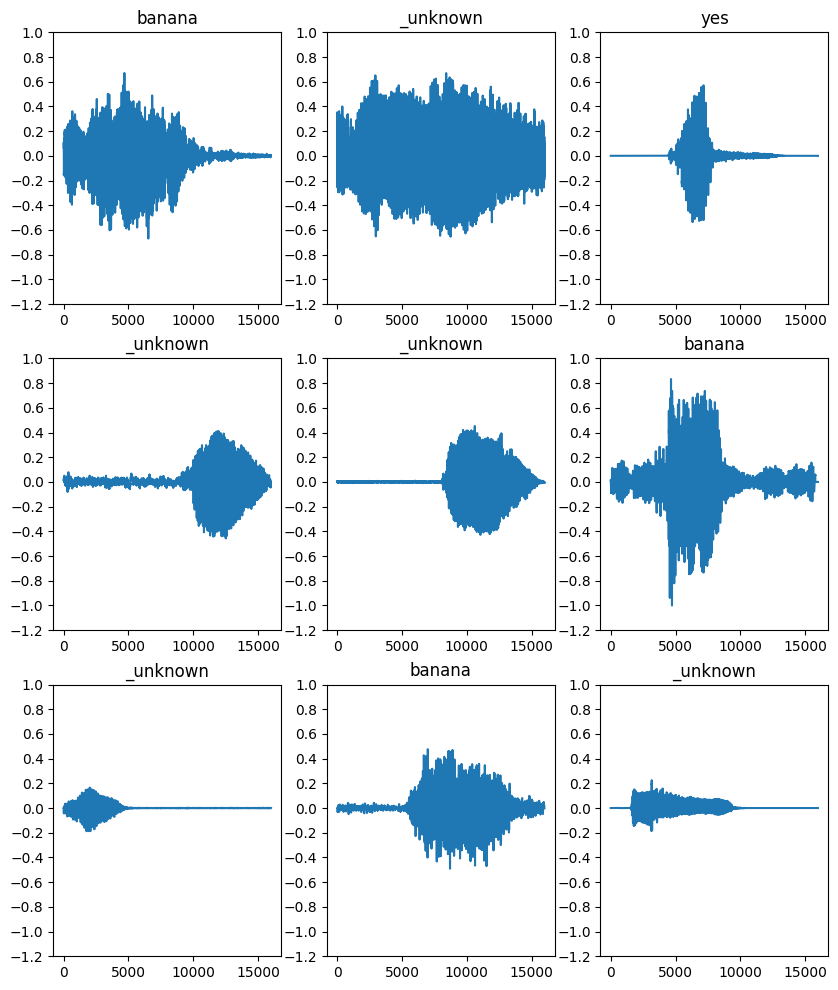

In [17]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

Functions for preprocessing

In [18]:
# Adds noise to waveforms
def copy_with_noise(ds_input, rms_level=0.25):
  rng = tf.random.Generator.from_seed(1234)
  wave_shape = tf.constant((wave_length_samps,))
  def add_noise(waveform, label):
    noise = rms_level*rng.normal(shape=wave_shape)
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)
    noisy_wave = waveform + noise
    return noisy_wave, label

  return ds_input.map(add_noise)

In [19]:
# waveform_ds = augment_with_noise(waveform_ds)
count = 0
for w,l in waveform_ds:
  if w.shape != (16000,):
    print(f"element {count} has shape {w.shape}")
    break
  count += 1
print(count)

element 35 has shape (11606,)
35


In [20]:
# Pads a waveform with 0s to ensure it has 16000 samples
def pad_16000(waveform, label):
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)
    return waveform, label

In [21]:
def count_labels(dataset):
    counts = {}
    for _, lbl in dataset:
        if lbl.dtype == tf.string:
            label = lbl.numpy().decode('utf-8')
        else:
            label = lbl.numpy()
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    return counts

In [22]:
# Collect what we did to generate the training dataset into a
# function, so we can repeat with the validation and test sets.
def preprocess_dataset(files, num_silent=None, noisy_reps_of_known=None):
  # if noisy_reps_of_known is not None, it should be a list of rms noise levels
  # For every target word in the data set, 1 copy will be created with each level
  # of noise added to it.  So [0.1, 0.2] will add 2x noisy copies of the target words
  if num_silent is None:
    num_silent = int(0.2*len(files))+1
  print(f"Processing {len(files)} files")
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(get_waveform_and_label)
  if noisy_reps_of_known is not None:
    # create a few copies of only the target words to balance the distribution
    # create a tmp dataset with only the target words
    ds_only_cmds = waveform_ds.filter(lambda w,l: tf.reduce_any(l == commands))
    for noise_level in noisy_reps_of_known:
       waveform_ds = waveform_ds.concatenate(copy_with_noise(ds_only_cmds, rms_level=noise_level))
  if num_silent > 0:
    silent_wave_ds = create_silence_dataset(num_silent, wave_length_samps,
                                            rms_noise_range=[0.01,0.2],
                                            silent_label=silence_str)
    waveform_ds = waveform_ds.concatenate(silent_wave_ds)
  print(f"Added {num_silent} silent wavs and ?? noisy wavs")
  num_waves = 0
  output_ds = wavds2specds(waveform_ds)
  return output_ds

In [23]:
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")

We have 9786/1600/3996 training/validation/test files


Testing preprocessing on a few files

In [24]:
# print(train_files[:20])
print(label_list)
train_files[:20]

tmp_ds = preprocess_dataset(train_files[:20])
print(count_labels(tmp_ds))

if tf.test.is_gpu_available():
    device_name = '/GPU:0'
    print('Running on GPU')
else:
    device_name = '/CPU:0'
    print('Running on CPU')

with tf.device(device_name):
    tmp_ds = preprocess_dataset(train_files[:20], noisy_reps_of_known=[0.05,0.1])
    print(count_labels(tmp_ds))

['_silence', '_unknown', 'yes', 'banana']
Processing 20 files
Added 5 silent wavs and ?? noisy wavs


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


About to create spectrograms from 25 waves
 0 wavs processed{3: 7, 1: 10, 2: 3, 0: 5}
Running on GPU
Processing 20 files
Added 5 silent wavs and ?? noisy wavs
About to create spectrograms from 45 waves
 0 wavs processed{3: 21, 1: 10, 2: 9, 0: 5}


Preprocess all files

In [25]:
from pathlib import Path
if tf.test.is_gpu_available():
    device_name = '/GPU:0'
    print('Running on GPU')
else:
    device_name = '/CPU:0'
    print('Running on CPU')

with tf.device(device_name):
    train_ds = preprocess_dataset(train_files, noisy_reps_of_known=[0.05,0.1,0.15,0.2,0.25])
    val_ds = preprocess_dataset(val_files)
    test_ds = preprocess_dataset(test_files)

Running on GPU
Processing 9786 files
Added 1958 silent wavs and ?? noisy wavs
About to create spectrograms from 34709 waves
 34500 wavs processedProcessing 1600 files
Added 321 silent wavs and ?? noisy wavs
About to create spectrograms from 1921 waves
 1750 wavs processedProcessing 3996 files
Added 800 silent wavs and ?? noisy wavs
About to create spectrograms from 4796 waves
 4750 wavs processed

Remove whitespace from .txt files and find the number of values in each dataset

In [26]:
def modify_testing_list(file_path):
    # Read all lines from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Remove the first line
    modified_lines = lines[1:]

    # Remove leading and trailing whitespace from each line
    modified_lines = [line.strip() for line in modified_lines]

    # Write the modified lines back to the file
    with open(file_path, 'w') as file:
        file.write('\n'.join(modified_lines))

# Specify the path to testing_list.txt
file_path = '/content/drive/My Drive/LaurenMLIoTFinalProject/dataset/testing_list.txt'  # LAUREN FILE PATH'

# Call the function to modify the file
modify_testing_list(file_path)

In [27]:
print("training data set")
print(count_labels(train_ds))
print("val_ds data set")
print(count_labels(val_ds))
print("test_ds data set")
print(count_labels(test_ds))

training data set
{3: 18174, 1: 5193, 2: 9384, 0: 1958}
val_ds data set
{3: 800, 2: 800, 0: 321}
test_ds data set
{3: 1996, 2: 2000, 0: 800}


Perform batching and ensure the input has the proper shape

In [28]:
train_ds = train_ds.shuffle(int(len(train_files)*1.2))
val_ds = val_ds.shuffle(int(len(val_files)*1.2))
test_ds = test_ds.shuffle(int(len(test_files)*1.2))

In [29]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [30]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [31]:
for spectrogram, _ in train_ds.take(1):
  spec1 = spectrogram
# take(1) takes 1 *batch*, so we have to select the first
# spectrogram from it, hence the [0]
print(f"Spectrogram shape {spec1[0].shape}")
print(f"ranges from {np.min(spec1)} to {np.max(spec1)}")   # min/max across the whole batch

Spectrogram shape (24, 32, 1)
ranges from 0.0 to 712.0


In [32]:
for spectrogram, _ in train_ds.take(1):
  # take(1) takes 1 *batch*, so we have to select the first
  # spectrogram from it, hence the [0]
  input_shape = spectrogram[0].shape
print('Input shape:', input_shape)
num_labels = len(label_list)


Input shape: (24, 32, 1)


In [33]:
label_list

['_silence', '_unknown', 'yes', 'banana']

In [34]:
print('Input shape:', input_shape)

Input shape: (24, 32, 1)


# CNN Model

Build model

In [109]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, DepthwiseConv2D, Dropout, MaxPooling2D, Flatten, Dense

In [53]:
def build_model(input_shape, num_labels, l2, lr):
    print('Input shape:', input_shape)
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(name='pool1'),

        layers.Conv2D(64, 3, kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(name='pool2'),

        layers.Conv2D(128, 3, kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(name='pool3'),

        layers.Flatten(),
        layers.Dense(256, kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(128, kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(num_labels),
    ], name="modified_simple_cnn")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.01,
        patience=4,
        verbose=2,
        mode='max',
        restore_best_weights=True)

    return model, early_stopping


In [55]:
l2_value=0.0001
lr=0.001
EPOCHS=50
model, early_stopping = build_model(input_shape, num_labels,l2_value, lr)
model.summary()

Input shape: (24, 32, 1)
Model: "modified_simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 22, 30, 32)        320       
                                                                 
 batch_normalization_16 (Ba  (None, 22, 30, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 22, 30, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 11, 15, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 9, 13, 64)         18496     
                                                                 
 batch_normalization_17 (Ba  (None, 9, 13, 64)         256       
 tchNormalization)    

In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import datetime


# Define the callbacks
checkpoint_callback = ModelCheckpoint(filepath='model.h5', monitor='val_accuracy', save_best_only=True)
tensorboard_callback = TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

# Train the model with the callbacks
history = model.fit(train_ds, validation_data=val_ds, epochs=10,
                    callbacks=[early_stopping, checkpoint_callback, tensorboard_callback])


Epoch 1/10
543/543 [==============================] - 53s 97ms/step - loss: 0.1534 - accuracy: 0.9667 - val_loss: 1.7735 - val_accuracy: 0.7054
Epoch 2/10
543/543 [==============================] - 43s 79ms/step - loss: 0.1320 - accuracy: 0.9726 - val_loss: 0.2281 - val_accuracy: 0.9334
Epoch 3/10
543/543 [==============================] - 42s 77ms/step - loss: 0.1164 - accuracy: 0.9788 - val_loss: 0.4451 - val_accuracy: 0.8423
Epoch 4/10
543/543 [==============================] - 44s 81ms/step - loss: 0.1066 - accuracy: 0.9814 - val_loss: 3.8430 - val_accuracy: 0.8173
Epoch 5/10
543/543 [==============================] - 41s 75ms/step - loss: 0.0962 - accuracy: 0.9859 - val_loss: 1.3354 - val_accuracy: 0.8037
Epoch 6/10
543/543 [==============================] - 43s 80ms/step - loss: 0.0905 - accuracy: 0.9865 - val_loss: 0.1418 - val_accuracy: 0.9714
Epoch 7/10
543/543 [==============================] - 41s 76ms/step - loss: 0.0852 - accuracy: 0.9888 - val_loss: 0.1767 - val_accuracy:

Save model as .h5 file

In [91]:
from google.colab import files

model_file_name = "ConvModelFinished.h5"
print(f"Saving model to {model_file_name}")
model.save(model_file_name, overwrite=True)

# Download the model file
files.download(model_file_name)


Saving model to ConvModelFinished.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
with open(model_file_name.split('.')[0] + '.txt', 'w') as fpo:
    fpo.write(f"i16min            = {i16min           }\n")
    fpo.write(f"i16max            = {i16max           }\n")
    fpo.write(f"fsamp             = {fsamp            }\n")
    fpo.write(f"wave_length_ms    = {wave_length_ms   }\n")
    fpo.write(f"wave_length_samps = {wave_length_samps}\n")
    fpo.write(f"window_size_ms    = {window_size_ms   }\n")
    fpo.write(f"window_step_ms    = {window_step_ms   }\n")
    fpo.write(f"num_filters       = {num_filters      }\n")
    fpo.write(f"use_microfrontend = {use_microfrontend}\n")
    fpo.write(f"label_list        = {label_list}\n")
    fpo.write(f"spectrogram_shape = {spectrogram.numpy().shape}\n")


Plot training and validation losses and accuracies

Text(0.5, 0, 'Epoch')

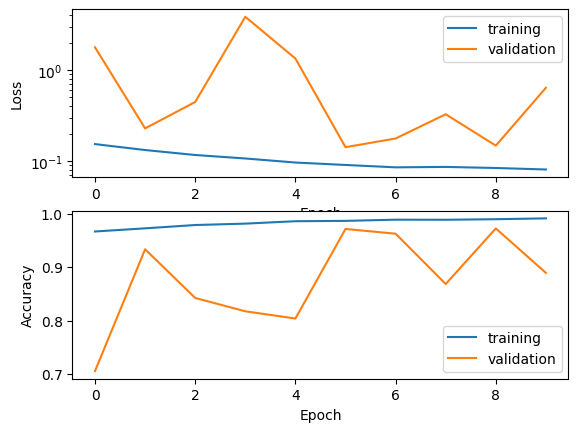

In [60]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable that stores the model training history
metrics = history.history

# Plot the training and validation loss on the top subplot
plt.subplot(2,1,1)
plt.semilogy(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Plot the training and validation accuracy on the bottom subplot
plt.subplot(2,1,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Save the plot as a PNG file
# plt.savefig('./figs/loss and acc.png', dpi=300, bbox_inches='tight')

In [61]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [62]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

150/150 [==============================] - 2s 14ms/step
Test set accuracy: 97%


Plot test set confusion matrix

_silence FRR: 0%
_unknown FRR: nan%
yes FRR: 8%
banana FRR: 0%


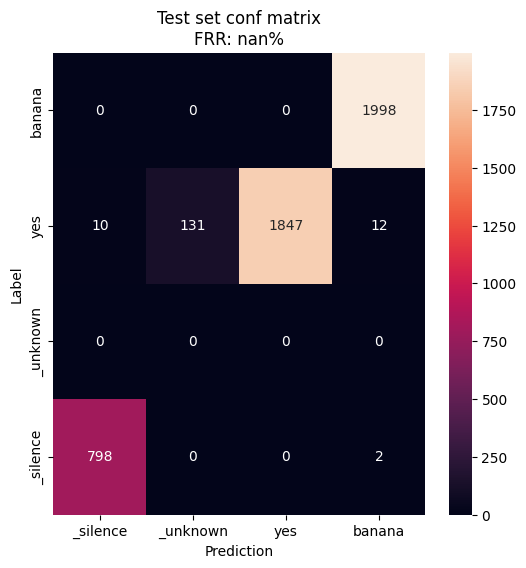

In [63]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

frr_list = []
for i in range(len(label_list)):
  tp = confusion_mtx[i][i]
  fn = sum(confusion_mtx[i]) - tp
  frr = fn / (fn + tp)
  frr_list.append(frr)
  print(f'{label_list[i]} FRR: {frr:.0%}')

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list,
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title(f'Test set conf matrix\nFRR: {np.mean(frr_list):.0%}')
plt.show()


Plot training set confusion matrix

On training set:
1085/1085 [==============================] - 13s 12ms/step
Data set accuracy: 91%
_silence FRR: 0%
_unknown FRR: 1%
yes FRR: 34%
banana FRR: 0%


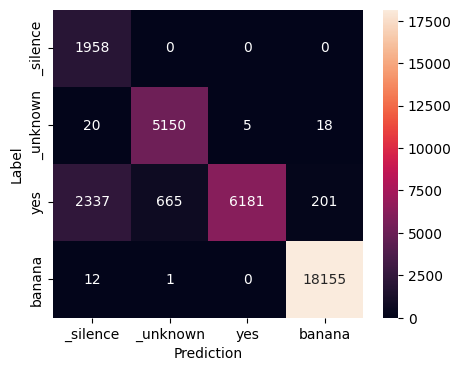

In [64]:
dset = train_ds.unbatch()
print("On training set:")

ds_audio = []
ds_labels = []

for audio, label in dset:
  ds_audio.append(audio.numpy())
  ds_labels.append(label.numpy())

ds_labels = np.array(ds_labels)
ds_audio = np.array(ds_audio)

model_out = model.predict(ds_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = ds_labels

ds_acc = sum(y_pred == y_true) / len(y_true)
print(f'Data set accuracy: {ds_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

frr_list = []
for i in range(len(label_list)):
  tp = confusion_mtx[i][i]
  fn = sum(confusion_mtx[i]) - tp
  frr = fn / (fn + tp)
  frr_list.append(frr)
  print(f'{label_list[i]} FRR: {frr:.0%}')

plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


Quantize and convert to TFLite

In [ ]:
import tensorflow as tf
import numpy as np

# Load the Keras model from .h5 file
model = tf.keras.models.load_model('ConvModelFinished.h5')

# Set up TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Disable experimental lowering of tensor list ops
converter._experimental_lower_tensor_list_ops = False

# Enable Select TensorFlow ops
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

# Set other converter settings as before
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()

def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        next_input = next(ds_iter)[0]
        next_input = next_input.astype(np.float32)
        yield [next_input]

converter.representative_dataset = representative_dataset_gen
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert the model to TensorFlow Lite format
tflite_quant_model = converter.convert()

# Save the TensorFlow Lite model to a .tflite file
tflite_file_name = 'model.tflite'
with open(tflite_file_name, "wb") as fpo:
    num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

# Convert the .tflite file to a .cc file
!xxd -i {tflite_file_name} > model.cc


# Save the TensorFlow Lite model to a .tflite file
tflite_file_name = 'model.tflite'
with open(tflite_file_name, "wb") as fpo:
    num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

# Convert the .tflite file to a .cc file
!xxd -i {tflite_file_name} > model.cc

# Download the C++ file
from google.colab import files
files.download('model.cc')

In [ ]:
# Download the .tflite file
from google.colab import files
files.download('model.tflite')

# GRU MODEL

Build model

In [115]:
from tensorflow.keras import layers, models, regularizers

def lstm_build_model(input_shape, num_labels, l2, lr):
    print('Input shape:', input_shape)
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(name='pool1'),

        layers.Conv2D(64, 3, kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(name='pool2'),

        layers.Conv2D(128, 3, kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(name='pool3'),

        layers.Flatten(),
        layers.Dense(256, kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(128, kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Reshape((-1, 128)),  # Reshape for LSTM layer
        layers.LSTM(128),  # Adjust the number of units to match the Dense layer
        layers.Dense(num_labels),
    ], name="modified_lstm_model")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.01,
        patience=4,
        verbose=2,
        mode='max',
        restore_best_weights=True)

    return model, early_stopping


In [117]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import datetime

l2_value=0.0001
lr=0.001
EPOCHS=50

# Create GRU model and early stopping callback
model, early_stopping = lstm_build_model(input_shape, num_labels, l2_value, lr)
model.summary()

# Define callbacks
checkpoint_callback = ModelCheckpoint(filepath='gru_model.h5', monitor='val_accuracy', save_best_only=True)
tensorboard_callback = TensorBoard(log_dir="logs/gru_fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

# Train the GRU model with the callbacks
gru_history = model.fit(train_ds, validation_data=val_ds, epochs=10,
                    callbacks=[early_stopping, checkpoint_callback, tensorboard_callback])


Input shape: (24, 32, 1)
Model: "modified_lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 22, 30, 32)        320       
                                                                 
 batch_normalization_70 (Ba  (None, 22, 30, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_70 (Activation)  (None, 22, 30, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 11, 15, 32)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 9, 13, 64)         18496     
                                                                 
 batch_normalization_71 (Ba  (None, 9, 13, 64)         256       
 tchNormalization)    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


543/543 [==============================] - 12s 12ms/step - loss: 0.3339 - accuracy: 0.8960 - val_loss: 1.5263 - val_accuracy: 0.7605
Epoch 2/10
543/543 [==============================] - 7s 13ms/step - loss: 0.1896 - accuracy: 0.9547 - val_loss: 1.4003 - val_accuracy: 0.8074
Epoch 3/10
543/543 [==============================] - 6s 10ms/step - loss: 0.1525 - accuracy: 0.9661 - val_loss: 1.0190 - val_accuracy: 0.8074
Epoch 4/10
543/543 [==============================] - 6s 12ms/step - loss: 0.1379 - accuracy: 0.9728 - val_loss: 1.3898 - val_accuracy: 0.8183
Epoch 5/10
543/543 [==============================] - 6s 12ms/step - loss: 0.1231 - accuracy: 0.9761 - val_loss: 1.6593 - val_accuracy: 0.6715
Epoch 6/10
543/543 [==============================] - 6s 12ms/step - loss: 0.1146 - accuracy: 0.9790 - val_loss: 0.5516 - val_accuracy: 0.8376
Epoch 7/10
543/543 [==============================] - 6s 11ms/step - loss: 0.1023 - accuracy: 0.9844 - val_loss: 0.2571 - val_accuracy: 0.9365
Epoch 8/1

Plot training and validation losses and accuracies

Text(0.5, 0, 'Epoch')

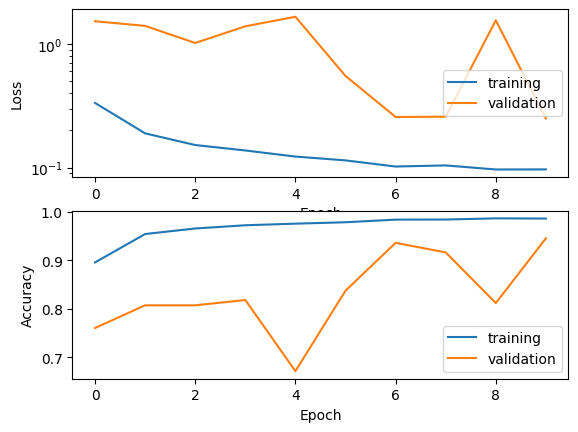

In [118]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable that stores the model training history
metrics = gru_history.history

# Plot the training and validation loss on the top subplot
plt.subplot(2,1,1)
plt.semilogy(gru_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Plot the training and validation accuracy on the bottom subplot
plt.subplot(2,1,2)
plt.plot(gru_history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Save the plot as a PNG file
# plt.savefig('./figs/loss and acc.png', dpi=300, bbox_inches='tight')

Save model as .h5 file

In [119]:
from google.colab import files

model_file_name = "GruModelFinished.h5"
print(f"Saving model to {model_file_name}")
model.save(model_file_name, overwrite=True)

# Download the model file
files.download(model_file_name)


Saving model to GruModelFinished.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Plot test set confusion matrix

In [120]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [121]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

150/150 [==============================] - 1s 3ms/step
Test set accuracy: 95%


_silence FRR: 1%
_unknown FRR: nan%
yes FRR: 12%
banana FRR: 0%


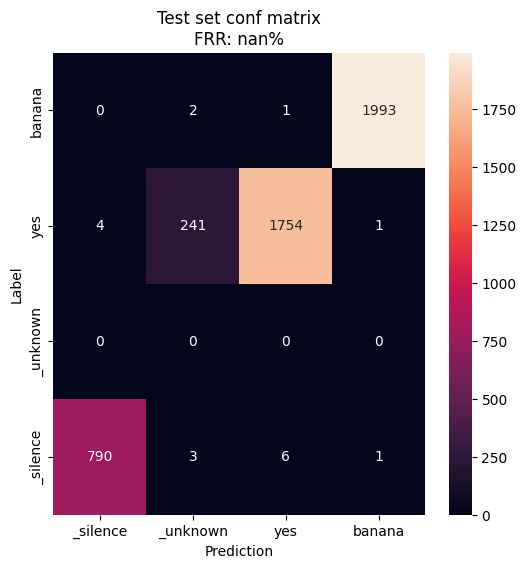

In [122]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

frr_list = []
for i in range(len(label_list)):
  tp = confusion_mtx[i][i]
  fn = sum(confusion_mtx[i]) - tp
  frr = fn / (fn + tp)
  frr_list.append(frr)
  print(f'{label_list[i]} FRR: {frr:.0%}')

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list,
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title(f'Test set conf matrix\nFRR: {np.mean(frr_list):.0%}')
plt.show()


Plot training set confusion matrix

On training set:
1085/1085 [==============================] - 4s 4ms/step
Data set accuracy: 96%
_silence FRR: 1%
_unknown FRR: 0%
yes FRR: 15%
banana FRR: 0%


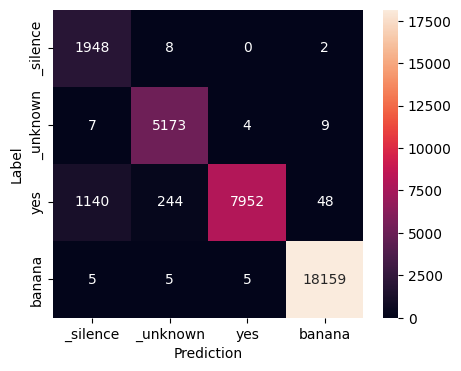

In [123]:
dset = train_ds.unbatch()
print("On training set:")

ds_audio = []
ds_labels = []

for audio, label in dset:
  ds_audio.append(audio.numpy())
  ds_labels.append(label.numpy())

ds_labels = np.array(ds_labels)
ds_audio = np.array(ds_audio)

model_out = model.predict(ds_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = ds_labels

ds_acc = sum(y_pred == y_true) / len(y_true)
print(f'Data set accuracy: {ds_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

frr_list = []
for i in range(len(label_list)):
  tp = confusion_mtx[i][i]
  fn = sum(confusion_mtx[i]) - tp
  frr = fn / (fn + tp)
  frr_list.append(frr)
  print(f'{label_list[i]} FRR: {frr:.0%}')

plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


Quantize and convert to TFLite

In [124]:
import tensorflow as tf
import numpy as np

# Load the Keras model from .h5 file
modelGRU = tf.keras.models.load_model('GruModelFinished.h5')

# Set up TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(modelGRU)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Disable experimental lowering of tensor list ops
converter._experimental_lower_tensor_list_ops = False

# Enable Select TensorFlow ops
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

# Set other converter settings as before
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()

def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        next_input = next(ds_iter)[0]
        next_input = next_input.astype(np.float32)
        yield [next_input]

converter.representative_dataset = representative_dataset_gen
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert the model to TensorFlow Lite format
tflite_quant_model = converter.convert()

# Save the TensorFlow Lite model to a .tflite file
tflite_file_name = 'modelLSTM.tflite'
with open(tflite_file_name, "wb") as fpo:
    num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

# Convert the .tflite file to a .cc file
!xxd -i {tflite_file_name} > modelGRU.cc


# Save the TensorFlow Lite model to a .tflite file
tflite_file_name = 'modelLSTM.tflite'
with open(tflite_file_name, "wb") as fpo:
    num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

# Convert the .tflite file to a .cc file
!xxd -i {tflite_file_name} > modelLSTM.cc

# Download the C++ file
from google.colab import files
files.download('modelLSTM.cc')

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Wrote 348880 / 348880 bytes to tflite file
Wrote 348880 / 348880 bytes to tflite file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
# Load the converted TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print input and output details
print("Input details:", input_details)
print("Output details:", output_details)


Input details: [{'name': 'serving_default_input_3:0', 'index': 0, 'shape': array([ 1, 24, 32,  1], dtype=int32), 'shape_signature': array([-1, 24, 32,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (2.792156934738159, -128), 'quantization_parameters': {'scales': array([2.792157], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 58, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.04807033762335777, -18), 'quantization_parameters': {'scales': array([0.04807034], dtype=float32), 'zero_points': array([-18], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [99]:
# Download the .tflite file
from google.colab import files
files.download('modelGRU.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>